# Conditional trajectory propagation and `TrajectoryFunctionWrappers`
This notebook shows how to propagte trajectories until certain conditions are met, e.g. a state is reached. It uses the `GmxEngine` to produce the trajectories and it will therefore only work if the gromacs executables are available (e.g. in your `$PATH` variable). It assumes familiarity with the `GmxEngine` class, it is therfore recommended to finish the `GmxEngine.ipynb` notebook first.

The two main classes you will use together:
 - `aimmd.distributed.PyTrajectoryFunctionWrapper`, a wrapper around any python function which can be applied to `aimmd.distributed.Trajectory` objects. The wrapped function is turned into an asyncronously callable subprocess and the results are cached for each trajectory such that reapplying a function is cheap. The `aimmd.distributed.SlurmTrajectoryFunctionWrapper` takes an executable instead of a python function and submits each calculation to the queueing system via SLURM.
 - The `aimmd.distributed.logic.TrajectoryPropagatoruntilAnyState` can be used to easily propagate a trajectory (possibly in chunks of walltime) until any of the given state functions are fullfilled, i.e. it is one of the basic building blocks of a committor simulation and can be reused in many transition path sampling algorithms

### Imports and some basic checks that everything is available

In [1]:
%%bash
# if using the module system to make gromacs and friends available:
# check that they are loaded!
#module list

In [2]:
%%bash
# unix only, check that gmx is available
which gmx

/usr/local/gromacs-2020.4/bin/gmx


In [3]:
%matplotlib inline

In [4]:
import os
import asyncio
import matplotlib.pyplot as plt
import numpy as np
import MDAnalysis as mda

In [5]:
import aimmd
import aimmd.distributed as aimmdd

Tensorflow/Keras not available


### Setup working directory and the number of simulations to run in parallel

In [6]:
n_engines = 3

#scratch_dir = "."
#scratch_dir = "/home/tb/hejung/DATA/aimmd_scratch/aimmd_distributed/"
scratch_dir = "/home/think/scratch/aimmd_distributed/"
wdirs = [os.path.join(scratch_dir, f"propagator_wdir{i}") for i in range(n_engines)]

for d in wdirs:
    if not os.path.isdir(d):
        os.mkdir(d)

## `aimmd.distributed.PyTrajectoryFunctionWrapper`
The `PyTrajectoryFunctionWrapper` can wrap any function that works on `aimmd.distributed.Trajectory` objects. It will remember a hash of the function and its call arguments and cache/store the results of the computation for quick later access. Additionally it turns a syncronous python function into an asyncronously callable (awaitable) by applying the function in a seperate subprocess to the trajectory. This enables the use of multiple cores by trivial parallelization, i.e. applying the same function to multiple differnt trajectories at once.

We will use the `PyTrajectoryFunctionWrapper` here to wrap the two state functions for capped alanine dipeptide. The content of the file `state_funcs_mda.py` is printed below. Please have a look at the state functions we import to make sure you understand what they return. You will need to be able to write state functions providing the state for every frame of a trajectory (i.e. the stoping conditions) for your molecular system of interest yourself to use `aimmd` to its full potential.

In addition to the state functions also contains some code for parsing command line arguments, which you can ignore for now. It contains this code because it can/will also be used as executable in the `SlurmTrajectoryFunctionWrapper`.

In [7]:
# this is just to have a look at the file content
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter
import IPython

with open('state_funcs_mda.py') as f:
    code = f.read()

formatter = HtmlFormatter()
IPython.display.HTML('<style type="text/css">{}</style>{}'.format(
    formatter.get_style_defs('.highlight'),
    highlight(code, PythonLexer(), formatter)))

### Import the state functions and wrap them
As you hopefully have guessed from the code above each state functions returns one value for every frame in the trajectory, i.e. their output is expected to be of shape `(len(trajectory),)` and the values simply indicate whether each frame is to be considered part of the respective state (`True`) or not (`False`).

In [8]:
from state_funcs_mda import C7_eq, alpha_R

In [9]:
C7_eq_wrapped = aimmdd.PyTrajectoryFunctionWrapper(C7_eq)
# the optional call_kwargs argument can be used to specify additional keyword arguments
# [we pass skip=1 which does not do anything because it is the default value only to show that call_kwargs exists]
alpha_R_wrapped = aimmdd.PyTrajectoryFunctionWrapper(alpha_R, call_kwargs={"skip": 1})

### Load two different configurations as `aimmd.distributed.Trajectory`

In [10]:
# create an aimmd.distributed.Trajectory of the initial configuration from the `GmxEngine.ipynb` notbook
init_conf = aimmdd.Trajectory(trajectory_file="gmx_infiles/conf_in_alphaR.trr",
                              structure_file="gmx_infiles/conf.gro",
                             )
# create a second aimmd.distributed.Trajectory of another configuration
other_conf = aimmdd.Trajectory(trajectory_file="gmx_infiles/conf_in_C7eq.trr",
                               structure_file="gmx_infiles/conf.gro",
                              )

### Apply the state functions to both configurations/trajectories simultaneously
We use `asyncio.gather` as usual to collect multiple tasks/coroutine executions and execute them all at once in the subprocesses to leverage the power of multiple cores.

In [11]:
import time
states = [alpha_R_wrapped, C7_eq_wrapped]

start = time.time()
states_for_init_conf = await asyncio.gather(*(sf(init_conf) for sf in states))
states_for_other_conf = await asyncio.gather(*(sf(other_conf) for sf in states))
end = time.time()

print(f"States (alphaR, C7_eq) for init_conf: {states_for_init_conf}.")
print(f"States (alphaR, C7_eq) for other_conf: {states_for_other_conf}.")
print(f"The calculation took {round(end-start, 4)} seconds")

States (alphaR, C7_eq) for init_conf: [array([ True]), array([False])].
States (alphaR, C7_eq) for other_conf: [array([False]), array([ True])].
The calculation took 2.529 seconds


### Applying the state functions again, we can observe that the result is obtained much faster because it has been cached
The caching applies to all wrapped functions, i.e. the return values of all wrapped functions operating on `aimmd.distributed.Trajectory` objects are cached. This means that all costly function operating on a trajectory will have to be evaluated only once the first time they are called, even if called multiple places in the code (e.g. because the order of execution was yet undetermined). One class of functions for which this is maybe even more crucial than for the state functions are the `descriptor_transform` functions, which will be used to transform from the molecular dynamics snapshots/trajctories to the space the machine learning models learn and predict in.

In [12]:
start = time.time()
states_for_init_conf = await asyncio.gather(*(sf(init_conf) for sf in states))
states_for_other_conf = await asyncio.gather(*(sf(other_conf) for sf in states))
end = time.time()

print(f"States (alphaR, C7_eq) for init_conf: {states_for_init_conf}.")
print(f"States (alphaR, C7_eq) for other_conf: {states_for_other_conf}.")
print(f"The 'calculation' took {round(end-start, 4)} seconds")

States (alphaR, C7_eq) for init_conf: [array([ True]), array([False])].
States (alphaR, C7_eq) for other_conf: [array([False]), array([ True])].
The 'calculation' took 0.0005 seconds


### As you can see each of the conformations is in one of the states
# `aimmd.distributed.logic.TrajectoryPropagatorUntilAnyState`
We will now use the `aimmd.distributed.logic.TrajectoryPropagatorUntilAnyState` to propagte a trajectory from each of the conformations until the other state is reached. Usually we will give a list of states to the `TrajectoryPropagatorUntilAnyState` and it will terminate as soon as any one of them is reached. However, since here each of the conformations is already in one of the states, we will need to setup two seperate propagators with one of the states each (for a propagator with all states both of the starting conforamtions already fulfill the stoping criterion "inside any of the states").

In [13]:
# propagator towards alphaR state (will be used for init_conf)
propa_towards_alphaR = aimmdd.logic.TrajectoryPropagatorUntilAnyState(states=[alpha_R_wrapped], # list of state functions to terminate on
                                                                      engine_cls=aimmdd.GmxEngine,
                                                                      engine_kwargs={"gro_file": "gmx_infiles/conf.gro",
                                                                                     "top_file": "gmx_infiles/topol_amber99sbildn.top",
                                                                                     #"mdrun_extra_args": "-ntomp 2",  # for gmx sans (thread)MPI
                                                                                     "mdrun_extra_args": "-nt 2",  # for gmx with (thrad)MPI
                                                                                     },
                                                                      run_config=aimmdd.MDP("gmx_infiles/md.mdp"),
                                                                      walltime_per_part=0.05,  # walltime of 180 s per part
                                                                      # we could set an upper boundary for the total number of steps/frames
                                                                      #max_frames=10000000,
                                                                     )
# propagator towards C7_eq state (for use with other_conf)
propa_towards_C7_eq = aimmdd.logic.TrajectoryPropagatorUntilAnyState(states=[C7_eq_wrapped],
                                                                     engine_cls=aimmdd.GmxEngine,
                                                                     engine_kwargs={"gro_file": "gmx_infiles/conf.gro",
                                                                                    "top_file": "gmx_infiles/topol_amber99sbildn.top",
                                                                                    #"mdrun_extra_args": "-ntomp 2",  # for gmx sans (thread)MPI
                                                                                    "mdrun_extra_args": "-nt 2",  # for gmx with (thrad)MPI
                                                                                    },
                                                                     run_config=aimmdd.MDP("gmx_infiles/md.mdp"),
                                                                     walltime_per_part=0.05,  # walltime of 180 s per part
                                                                    )

### We will use the `propagate_and_concatenate()` method which directly concatenates the generated trajectory parts into one trajectory until the first state is reached.
We could however also use the `propagate()` method to get back a list of trajectory parts as soon as the first state is reached. If we would like we could then later concatenate the list of trajecory parts using the `concatenate()` method but maybe you rather want to use it as input to another function to construct a complete transition from two lists of trajectory parts going into different states and do the concatenation only once.

The bottom line is: This class is thought as building block for more complex algorithms it is possible to call almost any of its functions independently. Have a look at the autocomplete and docstrings to find the functions that suit your workflow.

In [14]:
# the `propagate_and_concatenate` method returns the tuple (traj_to_state, idx_of_first_state_reached)
# since both propagators only have one state we can directly discard that meaningless information (the idx is going to be zero in both cases)
# Using asyncio.gather as usual to do both MD runs in parallel 
(traj_to_alphaR, _), (traj_to_C7eq, _) = await asyncio.gather(propa_towards_alphaR.propagate_and_concatenate(
                                                                                        starting_configuration=other_conf,
                                                                                        workdir=wdirs[0],
                                                                                        deffnm="towards_alphaR",
                                                                                        tra_out=os.path.join(wdirs[0], "traj_to_alphaR.trr")
                                                                                                             ),
                                                              propa_towards_C7_eq.propagate_and_concatenate(
                                                                                        starting_configuration=init_conf,
                                                                                        workdir=wdirs[1],
                                                                                        deffnm="towards_C7_eq",
                                                                                        tra_out=os.path.join(wdirs[1], "traj_to_C7_eq.trr")
                                                                                                            )
                                                              )

In [15]:
print(f"The trajectory towards alphaR has {len(traj_to_alphaR)} frames, the one towards C7_eq has {len(traj_to_C7eq)} frames.")

The trajectory towards alphaR has 5319 frames, the one towards C7_eq has 4023 frames.


### Extract a frame not belonging to any state from the trjectory towards ${\alpha}_{R}$.
We will use the `aimmd.distributed.trajectory.NoModificationFrameExtractor` for that. There are some more `FrameExtractors` in case you are interested have a look at the autocomplete of the `aimmd.distributed.trajectory` module.

In [16]:
extractor = aimmdd.trajectory.NoModificationFrameExtractor()  # instatiate extractor
# find out which frames are in no state
frame_in_no_state = np.logical_not((await alpha_R_wrapped(traj_to_alphaR)) | (await C7_eq_wrapped(traj_to_alphaR)))

print(f"There are {np.sum(frame_in_no_state)} frames not in any state.")

There are 280 frames not in any state.


In [17]:
# these are the indices of the frames not in any state
# there should be a continous strip of indices at the end, this is a complete transition from C7_eq to alphaR
np.where(frame_in_no_state)[0]

array([   7,    8,    9,   16,   18,   20,   21,   22,   24,   41,   42,
         43,   44,   45,   46,   47,  415,  759,  760,  761, 1227, 1228,
       1229, 1230, 1231, 1232, 1233, 1234, 1235, 1382, 1386, 1387, 1389,
       1622, 1810, 1811, 1844, 1976, 1977, 1978, 1979, 1980, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2050, 2547, 2548, 2549, 2550, 2551,
       2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562,
       2563, 2564, 2565, 2566, 2567, 2632, 2633, 2634, 2635, 2636, 2637,
       2638, 2639, 2640, 2641, 2694, 2695, 2715, 2782, 2785, 2786, 2814,
       2815, 2816, 2817, 2818, 2819, 2820, 3416, 3628, 3629, 3630, 3632,
       3633, 3636, 3645, 3646, 3647, 3648, 3649, 3650, 3652, 3653, 3665,
       3666, 3668, 3669, 3765, 3767, 3769, 3770, 3913, 3914, 3917, 3964,
       3965, 3966, 3967, 4314, 4470, 4471, 4472, 4473, 4538, 4540, 4541,
       4542, 4543, 4544, 4546, 4548, 4549, 4550, 4551, 4553, 4554, 4555,
       4583, 4594, 4596, 4598, 4599, 4600, 4611, 51

In [18]:
# write out the structure
tp_conf = extractor.extract(outfile=os.path.join(wdirs[2], "first_frame.trr"),
                            traj_in=traj_to_alphaR,
                            idx=np.where(frame_in_no_state)[0][-10], # (probably) takes a frame from the transition
                            )

In [19]:
tp_conf

Trajectory(trajectory_file=/home/think/scratch/aimmd_distributed/propagator_wdir2/first_frame.trr, structure_file=/home/think/scratch/aimmd_distributed/propagator_wdir0/towards_alphaR.tpr)

In [20]:
# instatiate a propagator towards any of the two states, this will finish as soon as the first is reached
states = [alpha_R_wrapped, C7_eq_wrapped]
propa_towards_any_state = aimmdd.logic.TrajectoryPropagatorUntilAnyState(states=states, # list of state functions to terminate on
                                                                         engine_cls=aimmdd.GmxEngine,
                                                                         engine_kwargs={"gro_file": "gmx_infiles/conf.gro",
                                                                                        "top_file": "gmx_infiles/topol_amber99sbildn.top",
                                                                                        #"mdrun_extra_args": "-ntomp 2",  # for gmx sans (thread)MPI
                                                                                        "mdrun_extra_args": "-nt 2",  # for gmx with (thrad)MPI
                                                                                     },
                                                                         run_config=aimmdd.MDP("gmx_infiles/md.mdp"),
                                                                         walltime_per_part=0.01,  # walltime of 36 s per part
                                                                        )

In [21]:
# and propagate, this time we care what state is reached
traj_to_first_state, first_state_reached = await propa_towards_any_state.propagate_and_concatenate(
                                                                                        starting_configuration=tp_conf,
                                                                                        workdir=wdirs[2],
                                                                                        deffnm="towards_any_state",
                                                                                        tra_out=os.path.join(wdirs[2], "traj_to_state.trr")
                                                                                                      )

### Extend the existing trial until the other state is reached.
Note that we could have also used the extractor with otherwise modified state functions to continue an existing trial. It will first check if any of the states are already reached and if not extend the trajectories until one of the current states is reached (or `max_frames`/`max_steps`).

In [22]:
propa_towards_other_state = aimmdd.logic.TrajectoryPropagatorUntilAnyState(
                                                                # take out the state we already reached from state functions list
                                                                states=[s for i, s in enumerate(states) if i != first_state_reached],
                                                                engine_cls=aimmdd.GmxEngine,
                                                                engine_kwargs={"gro_file": "gmx_infiles/conf.gro",
                                                                               "top_file": "gmx_infiles/topol_amber99sbildn.top",
                                                                               #"mdrun_extra_args": "-ntomp 2",  # for gmx sans (thread)MPI
                                                                               "mdrun_extra_args": "-nt 2",  # for gmx with (thrad)MPI
                                                                               },
                                                                run_config=aimmdd.MDP("gmx_infiles/md.mdp"),
                                                                walltime_per_part=0.05,  # walltime of 180 s per part
                                                                          )

### This time we will do a continuation!
Note that we need to use the same `workdir` and `deffnm` as before to make the continuation work.

In [23]:
# and propagate until the other state is reached
traj_to_second_state, second_state_reached = await propa_towards_other_state.propagate_and_concatenate(
                                                                                    starting_configuration=tp_conf,
                                                                                    # NOTE: need to use the same workdir as above,
                                                                                    #       otherwise we can not continue
                                                                                    workdir=wdirs[2],
                                                                                    deffnm="towards_any_state",
                                                                                    tra_out=os.path.join(wdirs[2], "traj_to_second_state.trr"),
                                                                                    # NOTE: this is the important keyword here!
                                                                                    continuation=True,        
                                                                                                    )

In [24]:
print(f"We now created two trajectories starting from {tp_conf},")
print(f"the first one going until state {first_state_reached} is a subtrajectory of the second trajectory which then goes until state {second_state_reached}.")
print(f"The first trajectory is {len(traj_to_first_state)} frames long, whereas the complete trajectory has {len(traj_to_second_state)} frames.")

We now created two trajectories starting from Trajectory(trajectory_file=/home/think/scratch/aimmd_distributed/propagator_wdir2/first_frame.trr, structure_file=/home/think/scratch/aimmd_distributed/propagator_wdir0/towards_alphaR.tpr),
the first one going until state 0 is a subtrajectory of the second trajectory which then goes until state 0.
The first trajectory is 11 frames long, whereas the complete trajectory has 2970 frames.


## Write out the continous transition from the second trajectory (which contains a transition from the state reached in the first round to the other state)

In [25]:
frames_in_no_state = np.logical_not((await alpha_R_wrapped(traj_to_second_state)) | (await C7_eq_wrapped(traj_to_second_state)))
print(frames_in_no_state)

[ True  True  True ...  True  True False]


In [26]:
traj_concat = aimmd.distributed.trajectory.TrajectoryConcatenator()

tp_end_frame = None  # always the last one, since we stop as soon as the state is reached

tp_start_frame = len(frames_in_no_state) - 2  # the last is always False
while frames_in_no_state[tp_start_frame]:
    tp_start_frame -= 1

In [27]:
constructed_tp = traj_concat.concatenate(trajs=[traj_to_second_state], slices=[(tp_start_frame, tp_end_frame, 1)],
                                         tra_out="TP_300K_amber99sbildn.trr", overwrite=True)

In [28]:
constructed_tp

Trajectory(trajectory_file=/home/think/Documents/sources/OPS/aimmd/examples/distributed/TP_300K_amber99sbildn.trr, structure_file=/home/think/scratch/aimmd_distributed/propagator_wdir2/towards_any_state.tpr)

In [29]:
len(constructed_tp)

/home/think/.conda/envs/aimmd_nature_publish/lib/python3.8/site-packages/MDAnalysis/coordinates/XDR.py:216: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


102

In [30]:
await alpha_R_wrapped(constructed_tp)

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [31]:
await C7_eq_wrapped(constructed_tp)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True])

In [32]:
from state_funcs_mda import descriptor_func_psi_phi

In [33]:
psi_phi_wrapped = aimmdd.PyTrajectoryFunctionWrapper(descriptor_func_psi_phi)

In [34]:
vals = await psi_phi_wrapped(constructed_tp)

In [35]:
#old_traj = aimmdd.Trajectory("gmx_infiles/old_files_backup/ala_400K_TP_low_barrier.trr", "gmx_infiles/old_files_backup/AD_initial_frame.pdb")

In [36]:
#vals_old = await psi_phi_wrapped(old_traj)

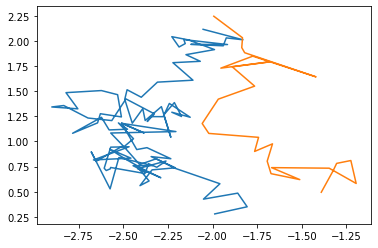

In [37]:
fig, axs = plt.subplots()

axs.plot(vals[1], vals[0])
#axs.plot(vals_old[1], vals_old[0])